# Project Setup and Dependencies


In [ ]:
!pip install requests pandas numpy matplotlib seaborn scikit-learn tensorflow plotly kaleido folium statsmodels --quiet

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import folium
import json
from datetime import datetime, timedelta
import time

print("Libraries installed and imported.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.9 MB/s eta 0:00:00
Libraries installed and imported.


# Configuration

In [ ]:
LATITUDE = 24.4898
LONGITUDE = 86.699
LOCATION_NAME = "Deoghar, IN"
HOURLY_VARIABLES = ["temperature_2m", "precipitation", "relativehumidity_2m"]

PAST_DAYS = 750


N_STEPS_LSTM = 5
N_FEATURES_LSTM = 1

ANOMALY_CONTAMINATION = 0.02

# Data Acquisition (Live API Call)

In [ ]:
def fetch_climate_data(latitude, longitude, past_days, hourly_vars):
    print(f"Fetching data for coordinates: ({latitude}, {longitude})")
    #BASE_URL = "https://archive-api.open-meteo.com/v1/archive"
    BASE_URL = "https://historical-forecast-api.open-meteo.com/v1/forecast"

    end_date = datetime.now().strftime('%Y-%m-%d')
    start_date = (datetime.now() - timedelta(days=past_days)).strftime('%Y-%m-%d')

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": ",".join(hourly_vars),
        "timezone": "auto"
    }

    try:
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        data = response.json()
        print("Data fetched successfully!")
        return data

    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return None
    except json.JSONDecodeError:
        print("Error decoding JSON response.")
        print("Response text:", response.text)
        return None


raw_data = fetch_climate_data(LATITUDE, LONGITUDE, PAST_DAYS, HOURLY_VARIABLES)


if raw_data:
    hourly_data = raw_data.get('hourly', {})
    df = pd.DataFrame(hourly_data)

    if 'time' not in df.columns or df.empty:
         print("Error: 'time' column not found in hourly data or data is empty.")
         print("Raw Data Structure:", raw_data)
         df = pd.DataFrame()
    else:
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
        print(f"\nDataframe created with shape: {df.shape}")
        print("\nFirst 5 rows:")
        print(df.head())
        print("\nLast 5 rows:")
        print(df.tail())
        print("\nData Info:")
        df.info()
else:
    print("Could not proceed without data.")
    df = pd.DataFrame()

Fetching data for coordinates: (24.4898, 86.699)
Data fetched successfully!

Dataframe created with shape: (18024, 3)

First 5 rows:
                     temperature_2m  precipitation  relativehumidity_2m
time                                                                   
2023-03-16 00:00:00            24.2            0.0                   53
2023-03-16 01:00:00            23.8            0.0                   53
2023-03-16 02:00:00            22.7            0.0                   60
2023-03-16 03:00:00            22.8            0.0                   59
2023-03-16 04:00:00            22.0            0.0                   61

Last 5 rows:
                     temperature_2m  precipitation  relativehumidity_2m
time                                                                   
2025-04-04 19:00:00            29.7            0.0                   40
2025-04-04 20:00:00            28.4            0.0                   42
2025-04-04 21:00:00            26.9            0.0           

# Data Preprocessing and Cleaning

In [ ]:
if not df.empty:

    print("\nMissing values per column:")
    print(df.isnull().sum())


    df.ffill(inplace=True)
    df.bfill(inplace=True)
    print("\nMissing values after forward/backward fill:")
    print(df.isnull().sum())


    for col in HOURLY_VARIABLES:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

    df.dropna(inplace=True)

    print(f"\nDataframe shape after cleaning: {df.shape}")
    print("\nBasic Statistics:")
    print(df.describe())
else:
    print("Skipping preprocessing as DataFrame is empty.")


Missing values per column:
temperature_2m         0
precipitation          0
relativehumidity_2m    0
dtype: int64

Missing values after forward/backward fill:
temperature_2m         0
precipitation          0
relativehumidity_2m    0
dtype: int64

Dataframe shape after cleaning: (18024, 3)

Basic Statistics:
       temperature_2m  precipitation  relativehumidity_2m
count    18024.000000   18024.000000         18024.000000
mean        25.390796       0.168958            70.329672
std          6.256146       0.772617            20.870379
min          7.300000       0.000000             9.000000
25%         21.400000       0.000000            57.000000
50%         26.300000       0.000000            76.000000
75%         29.300000       0.000000            87.000000
max         43.100000      36.200000           100.000000


# Exploratory Data Analysis (EDA) & Visualization

In [ ]:
if not df.empty:
    print("\n--- Generating Visualizations ---")


    print("\nPlotting Time Series...")
    fig_ts = go.Figure()

    for col in HOURLY_VARIABLES:
        fig_ts.add_trace(go.Scatter(x=df.index, y=df[col], mode='lines', name=col))

    fig_ts.update_layout(
        title=f'Hourly Climate Variables for {LOCATION_NAME} (Last {PAST_DAYS} Days)',
        xaxis_title='Time',
        yaxis_title='Value',
        legend_title='Variable',
        hovermode="x unified"
    )
    fig_ts.show()


    print("\nPlotting Distributions...")
    for col in HOURLY_VARIABLES:
      fig_hist = px.histogram(df, x=col, title=f'Distribution of {col}')
      fig_hist.show()


    print("\nGenerating Location Map...")
    m = folium.Map(location=[LATITUDE, LONGITUDE], zoom_start=10)
    folium.Marker(
        [LATITUDE, LONGITUDE],
        popup=f"{LOCATION_NAME}\nLat: {LATITUDE}\nLon: {LONGITUDE}",
        tooltip=LOCATION_NAME
    ).add_to(m)
    display(m)

else:
    print("Skipping Visualization as DataFrame is empty.")


--- Generating Visualizations ---

Plotting Time Series...



Plotting Distributions...



Generating Location Map...


# Climate Prediction Model (Short-Term Temperature Forecast - LSTM)


--- Building Short-Term Temperature Forecast Model (LSTM) ---
Training data shape: X=(14415, 5, 1), y=(14415, 1)
Testing data shape: X=(3604, 5, 1), y=(3604, 1)

Training LSTM model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Training complete.


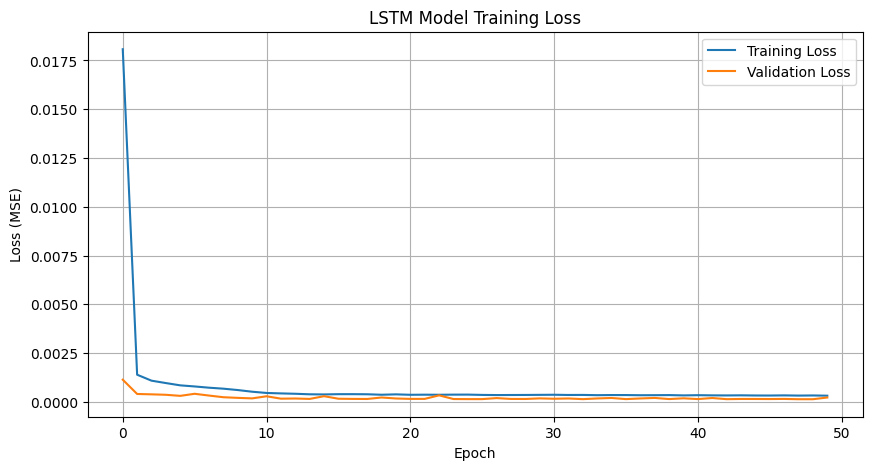

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Plotting Forecast vs Actual...



Mean Absolute Error (MAE) on Test Set: 0.58 °C
R-squared (R2) Score on Test Set: 0.98

Note: This is a simple short-term forecast based only on recent temperature history.


In [ ]:
if not df.empty and 'temperature_2m' in df.columns and len(df) > N_STEPS_LSTM * 2:
    print("\n--- Building Short-Term Temperature Forecast Model (LSTM) ---")


    temp_data = df['temperature_2m'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(temp_data)


    def create_sequences(data, n_steps):
        X, y = [], []
        for i in range(len(data)):
            end_ix = i + n_steps
            if end_ix > len(data)-1:
                break
            seq_x, seq_y = data[i:end_ix], data[end_ix]
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

    X, y = create_sequences(scaled_data, N_STEPS_LSTM)


    X = X.reshape((X.shape[0], X.shape[1], N_FEATURES_LSTM))


    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    time_index_test = df.index[N_STEPS_LSTM:][split_idx:]

    print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
    print(f"Testing data shape: X={X_test.shape}, y={y_test.shape}")


    model_lstm = Sequential()
    model_lstm.add(LSTM(50, activation='relu', input_shape=(N_STEPS_LSTM, N_FEATURES_LSTM)))
    model_lstm.add(Dense(1))
    model_lstm.compile(optimizer='adam', loss='mse')

    print("\nTraining LSTM model...")

    history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0)
    print("Training complete.")


    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTM Model Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    plt.show()



    y_pred_scaled = model_lstm.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_test_actual = scaler.inverse_transform(y_test)


    print("\nPlotting Forecast vs Actual...")
    fig_pred = go.Figure()
    fig_pred.add_trace(go.Scatter(x=time_index_test, y=y_test_actual.flatten(), mode='lines', name='Actual Temperature'))
    fig_pred.add_trace(go.Scatter(x=time_index_test, y=y_pred.flatten(), mode='lines', name='Predicted Temperature (LSTM)'))

    fig_pred.update_layout(
        title=f'Temperature Forecast vs Actual for {LOCATION_NAME} (Test Set)',
        xaxis_title='Time',
        yaxis_title='Temperature (°C)',
        legend_title='Data',
         hovermode="x unified"
    )
    fig_pred.show()


    mae = np.mean(np.abs(y_pred - y_test_actual))
    print(f"\nMean Absolute Error (MAE) on Test Set: {mae:.2f} °C")

    r2 = r2_score(y_test_actual, y_pred)
    print(f"R-squared (R2) Score on Test Set: {r2:.2f}")

    print("\nNote: This is a simple short-term forecast based only on recent temperature history.")


else:
     print("Skipping Prediction: DataFrame is empty, 'temperature_2m' column is missing, or not enough data points.")

# Anomaly Detection (using Isolation Forest)

In [ ]:
if not df.empty and 'temperature_2m' in df.columns:
    print("\n--- Performing Anomaly Detection on Temperature Data ---")


    model_iforest = IsolationForest(n_estimators=100, contamination=ANOMALY_CONTAMINATION, random_state=42)

    temp_data_if = df[['temperature_2m']].copy()
    model_iforest.fit(temp_data_if)

    df['anomaly_temp'] = model_iforest.predict(temp_data_if)


    anomalies = df[df['anomaly_temp'] == -1]
    print(f"\nDetected {len(anomalies)} potential anomalies in temperature data.")


    print("\nPlotting Temperature with Detected Anomalies...")
    fig_anomaly = go.Figure()


    fig_anomaly.add_trace(go.Scatter(
        x=df.index,
        y=df['temperature_2m'],
        mode='lines',
        name='Temperature (°C)'
    ))


    fig_anomaly.add_trace(go.Scatter(
        x=anomalies.index,
        y=anomalies['temperature_2m'],
        mode='markers',
        marker=dict(color='red', size=8, symbol='x'),
        name='Detected Anomaly'
    ))

    fig_anomaly.update_layout(
        title=f'Temperature Time Series with Anomaly Detection for {LOCATION_NAME}',
        xaxis_title='Time',
        yaxis_title='Temperature (°C)',
        legend_title='Data',
         hovermode="x unified"
    )
    fig_anomaly.show()

    if not anomalies.empty:
      print("\nDetails of detected anomalies:")
      print(anomalies[['temperature_2m', 'anomaly_temp']])

else:
    print("Skipping Anomaly Detection: DataFrame is empty or 'temperature_2m' column is missing.")


--- Performing Anomaly Detection on Temperature Data ---

Detected 351 potential anomalies in temperature data.

Plotting Temperature with Detected Anomalies...



Details of detected anomalies:
                     temperature_2m  anomaly_temp
time                                             
2023-04-14 12:00:00            40.4            -1
2023-04-14 13:00:00            40.7            -1
2023-04-14 14:00:00            40.6            -1
2023-04-15 13:00:00            40.4            -1
2023-04-15 14:00:00            40.3            -1
...                             ...           ...
2025-01-11 06:00:00            10.2            -1
2025-01-11 07:00:00            10.5            -1
2025-01-24 06:00:00            10.8            -1
2025-01-24 07:00:00            10.8            -1
2025-01-27 06:00:00            10.5            -1

[351 rows x 2 columns]


# Simple Dashboard / Summary Visualization

In [ ]:


if not df.empty:
    print("\n--- Summary Dashboard Components ---")


    print("\n1. Time Series Overview:")
    if 'fig_ts' in locals():
      fig_ts.show()
    else:
      print("Time series plot not available.")


    print("\n2. Temperature Forecast (Test Set):")
    if 'fig_pred' in locals():
        fig_pred.show()
    else:
      print("Forecast plot not available.")

    print("\n3. Temperature Anomaly Detection:")
    if 'fig_anomaly' in locals():
        fig_anomaly.show()
    else:
      print("Anomaly plot not available.")


    print("\n4. Location Context:")
    if 'm' in locals():
      display(m)
    else:
      print("Map not available.")

else:
    print("Cannot generate summary dashboard components as DataFrame is empty.")


--- Summary Dashboard Components ---

1. Time Series Overview:



2. Temperature Forecast (Test Set):



3. Temperature Anomaly Detection:



4. Location Context:


# Predicting 24 Hrs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


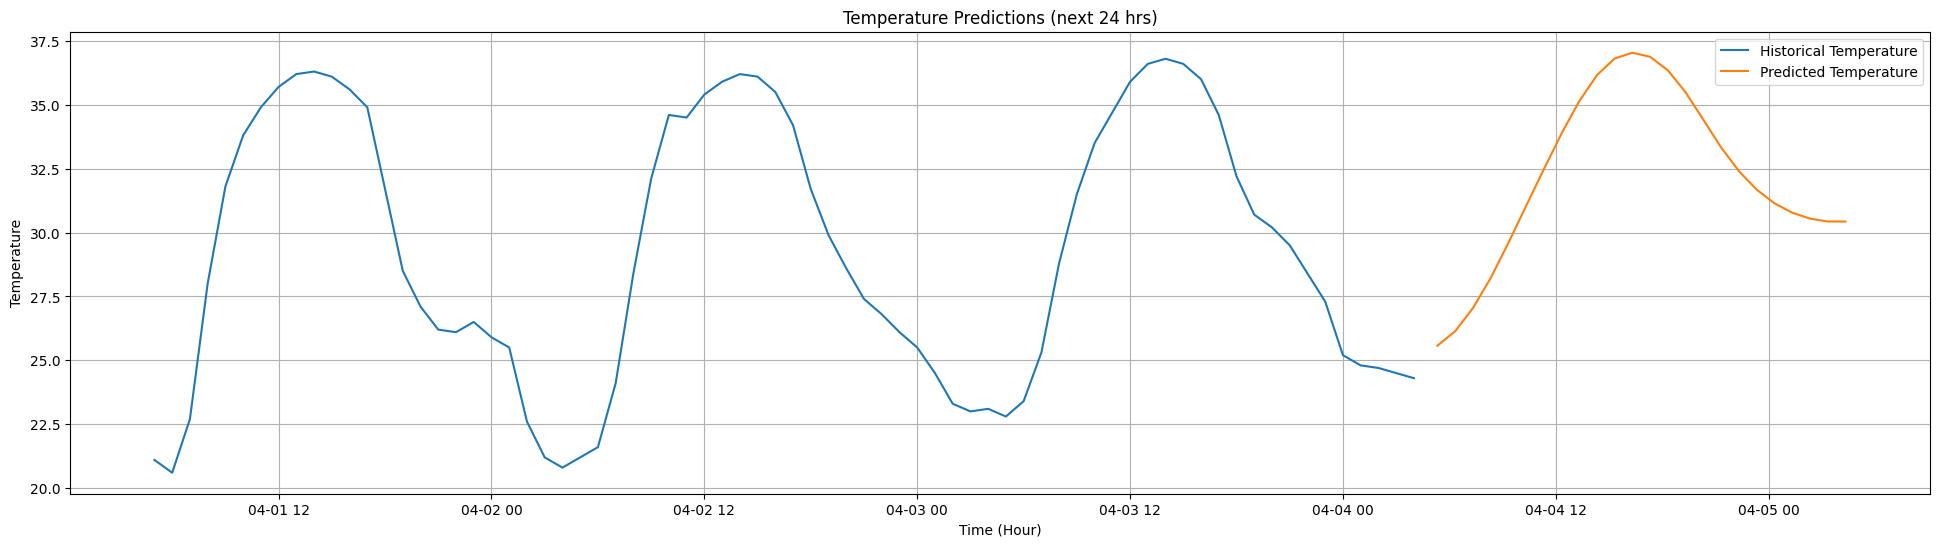

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def predict_next_24_hours(model, scaler, last_data_points):

    predictions = []
    current_sequence = last_data_points.copy()
    for _ in range(24):

        X = np.array([current_sequence]).reshape(1, N_STEPS_LSTM, N_FEATURES_LSTM)


        next_value_scaled = model.predict(X)
        next_value = scaler.inverse_transform(next_value_scaled)[0,0]


        predictions.append(next_value)
        current_sequence = np.append(current_sequence[1:], next_value_scaled)

    return np.array(predictions)


if not df.empty and 'temperature_2m' in df.columns and len(df) > N_STEPS_LSTM * 2:

    last_data_points_scaled = scaler.transform(df['temperature_2m'][-N_STEPS_LSTM:].values.reshape(-1, 1))
    last_data_points = last_data_points_scaled.flatten()

    predicted_temps = predict_next_24_hours(model_lstm, scaler, last_data_points)


    now = datetime.now()
    prediction_times = [now + timedelta(hours=i) for i in range(1, 25)]


    prediction_df = pd.DataFrame({'time': prediction_times, 'predicted_temperature': predicted_temps})
    prediction_df = prediction_df.set_index('time')



    three_days_ago = now - timedelta(days=3)
    plot_start = max(three_days_ago, df.index.min())
    plot_end = now + timedelta(hours=24)

    plt.figure(figsize=(24, 6))

    plt.plot(df['temperature_2m'][plot_start: now], label='Historical Temperature')

    plt.plot(prediction_df.index, prediction_df['predicted_temperature'], label='Predicted Temperature')

    plt.xlabel("Time (Hour)")
    plt.ylabel("Temperature")
    plt.title("Temperature Predictions (next 24 hrs)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Not enough data or necessary column 'temperature_2m' not found.")
